In [1]:
import jax
import jax.numpy as np
import jax.lax as lax
import matplotlib.pyplot as plt

In [2]:
import tools.assign as ps

In [3]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [4]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [5]:
# algo params
N = 100
f_lo, f_hi = 0.5, 1.5

In [6]:
# model parameters
par = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

## Grid

In [64]:
# algo parameters
alg_grid = {
    'N': 100,
    'flo': 0.5,
    'fhi': 1.5,
    'ε': 1e-6,
}

In [65]:
vfi_grid = ps.ValfuncGrid(par, alg_grid)

In [66]:
vp, kp = vfi_grid.solve()

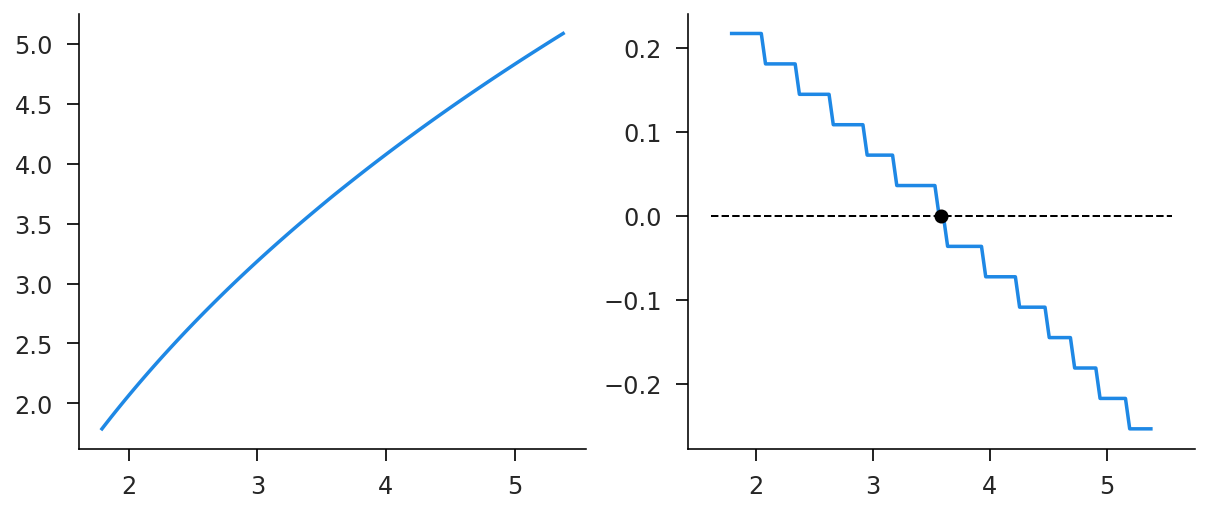

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(vfi_grid.k_grid, vp);
ax[1].plot(vfi_grid.k_grid, kp-vfi_grid.k_grid);
ax[1].scatter(vfi_grid.kss, 0, c='k', zorder=10);
ax[1].hlines(0, *ax[1].get_xlim(), color='k', linestyle='--', linewidth=1);

In [68]:
def solve_param(p):
    vfi = ps.ValfuncGrid(p, alg_grid)
    v, kp = vfi.solve()
    return np.std(kp)

In [69]:
d_solve_param = jax.jit(jax.grad(solve_param))

In [70]:
d_solve_param(par)

{'z': DeviceArray(1.3850073, dtype=float32, weak_type=True),
 'α': DeviceArray(5.7255116, dtype=float32, weak_type=True),
 'β': DeviceArray(10.054498, dtype=float32, weak_type=True),
 'δ': DeviceArray(-9.074184, dtype=float32, weak_type=True)}

## Interp

In [62]:
# algo parameters
alg_interp = {
    'N': 500,
    'flo': 0.5,
    'fhi': 1.5,
    'ε': 1e-6,
    'Δk': 0.01,
    'Δv': 0.01,
    'vlo': -10.0,
    'vhi': 10.0,
}

In [63]:
vfi_interp = ps.ValfuncInterp(par, alg_interp)

In [64]:
vp, kp = vfi_interp.solve(K=5000)

0 0.008281231 0.0022259653
1000 0.010000229 0.005697727
2000 0.010000229 0.0029325485
3000 0.010000229 0.0017127991
4000 0.00999999 0.001004219
5000 0.00999999 0.0006389618


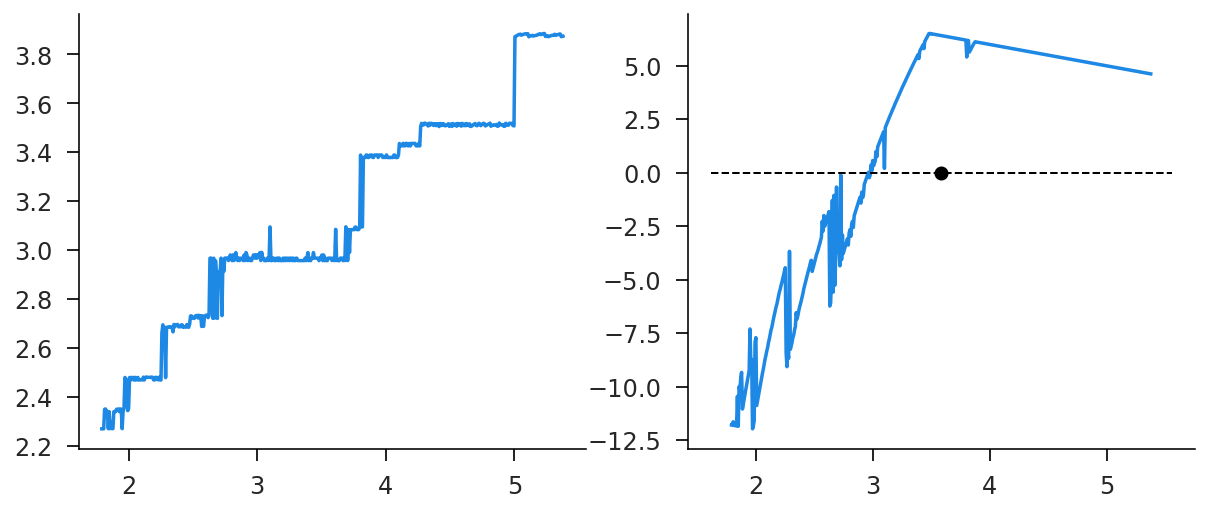

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(vfi.k_grid, vp);
ax[1].plot(vfi.k_grid, kp-vfi.k_grid);
ax[1].scatter(vfi.kss, 0, c='k', zorder=10);
ax[1].hlines(0, *ax[1].get_xlim(), color='k', linestyle='--', linewidth=1);